# Deep Convolutional GAN (DCGAN)

Generative Adversarial Networks, or GANs for short, are an approach to **Generative Modeling** using deep learning methods. Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

The GAN model architecture involves two sub-models: a generator model for generating new examples and a discriminator model for classifying whether generated examples are real, from the domain, or fake, generated by the generator model.
- **Generator:** Model that is used to generate new plausible examples from the problem domain.
- **Discriminator:** Model that is used to classify examples as real (from the domain) or fake (generated).

**Application of GANs:**
* Generate Examples for Image Datasets(i.e, medical data such as X-ray, MRI)
* Super Resolution
* Clothing Translation
* 3D Object Generation
* Text-to-Image Translation


Here is the implementation of a **Deep Convolutional GAN(DCGAN)** on MNIST dataset.
In this Notebook, we will see how to,
   * Load torchvision dataset
   * Create Generator network
   * Create Discriminator network
   * Train GAN
   * Evaluate GAN during training by plotting results of Generator

## Import Packages

In [12]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch.optim as optim
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [13]:
# Function to visualizing images from tensor

def show_tensor_images(tensor_img, num_img=25, size=(1, 28, 28)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

DCGAN is a very successful and influential GAN model developed in 2015. Most GANs today are at least loosely based on the DCGAN architecture.

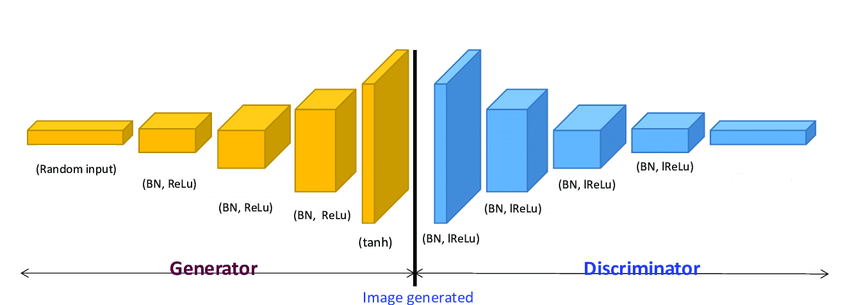

Here are the main features of DCGAN:
*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation
*   Both Generator and Discriminator use 4 layers as 3 hidden layers and 1 output layer


## Load data

In these cells we are going to load MNIST dataset from torchvision datasets and apply transforms and creating Dataloader. After that visualization has been done so we can be familier with the dataset.

In [14]:
# More transforms can be added
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(
    MNIST('data/', download=True, transform=transform),
    batch_size=128,
    shuffle=True)

Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


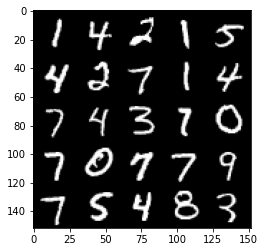

In [15]:
# Display images from train_loader

dataiter = iter(train_loader)
images,labels = dataiter.next()
print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(train_loader))

show_tensor_images(images)

## Generator

In [16]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, img_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, 128, stride = 1, padding = 0),
            self.gen_block(128, 64),
            self.gen_block(64, 32),
            self.gen_block(32, 1, final_layer = True),
        )

    def gen_block(self, input_channel, output_channel, kernel_size=3, stride=2, padding = 1, final_layer=False):
        '''
        Function that return a basic Sequential block for the Generator of DCGAN, corresponding to
            - Transposed Convolution
            - Batchnorm (except for in the last layer)
            - Activation
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel , 4, stride = stride, padding = padding, bias=False),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, 4, stride = stride, padding = padding, bias=False),#input_channel, output_channel, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, x):
        # change the shape: (batch_size, channels=z_dim, width=1, height=1)
        # x = self.gen_block(x, 512, 3, 2)
        # x = self.gen_block(x, 256, 3, 2)
        # x = self.gen_block(x, 128, 3, 2)
        # x = self.gen_block(x, 64, 3, 2, 0, True)
        x = x.view(len(x), self.z_dim, 1, 1)
        return self.gen(x)

## Discriminator

In [17]:
class Discriminator(nn.Module):

    def __init__(self, img_channel=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # self.disc_block(img_channel, hidden_dim),
            # self.disc_block(hidden_dim, hidden_dim * 2),
            # self.disc_block(hidden_dim * 2, 1, final_layer=True),
            self.disc_block(1, 32),
            self.disc_block(32, 64),
            self.disc_block(64, 128, kernel_size=3),
            self.disc_block(128, 1, final_layer=True),
        )
        # self.nn_layers = nn.ModuleList()

    def disc_block(self, input_channel, output_channel, kernel_size=3, stride=0, final_layer=False):
        '''
        Function that return a basic Sequential block for the Discriminator of DCGAN, corresponding to
            - Convolution
            - Batchnorm (except for in the last layer)
            - LeakyReLU activation with 0.2 slope of the leak
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size = kernel_size, stride = stride, padding = 1, bias=False),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride),
                nn.Flatten(),
                nn.Sigmoid()
            )
  
    def forward(self, image):
        # returns 1-dimension tensor representing fake/real
        # image = self.disc_block(image, 64)
        # image = self.disc_block(image, 128)
        # image = self.disc_block(image, 256)
        # image = self.disc_block(image, 512)
        # return self.disc_block(image, 1)
        image = self.disc(image).view(len(self.disc(image)), -1)
        return image

## Initialize Generator and Discriminator

In [18]:
# required parameters for training

z_dim = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

G = G.apply(weights_init)
D = D.apply(weights_init)

## Define loss and Optimizer 

In [20]:
beta_1 =  0.5        # parameters control the optimizer's momentum
beta_2 =  0.99     # parameters control the optimizer's momentum
lr = 0.0002 
G_opt = optim.Adam(G.parameters(), lr = lr, betas=(beta_1, beta_2))
D_opt = optim.Adam(D.parameters(), lr = lr, betas=(beta_1, beta_2))

criterion = nn.BCELoss() 

# 'BinaryCrossEntropy Loss' is used to evaluate how well dicriminator and generator performs
def real_loss(disc_pred, y = None):
    real_targets = torch.ones(disc_pred.size(0), 1, device=device)
    return criterion(real_targets, disc_pred)

def fake_loss(disc_pred, y = None):
    fake_targets = torch.zeros(disc_pred.size(0), 1, device=device)
    return criterion(fake_targets, disc_pred)


## Training

Here's roughly progression of DCGAN. On GPU this takes about 17-18 seconds per thousand steps. On CPU, this can take more than 4 hours per thousand steps.

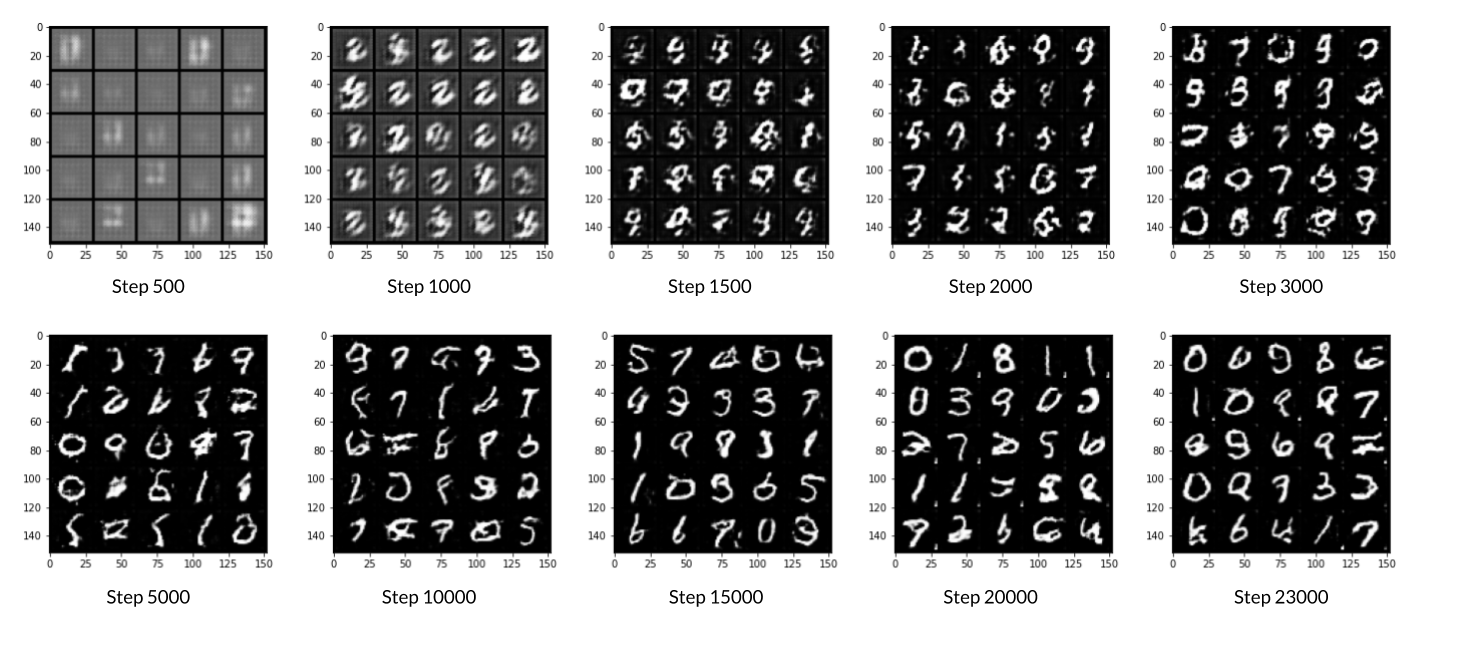

In [21]:
display_step = 1000      # how often to display/visualize the images

epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

Step 1000: Generator loss: 2.3241930397152895, discriminator loss: 0.20953824805561455


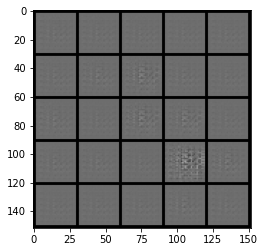

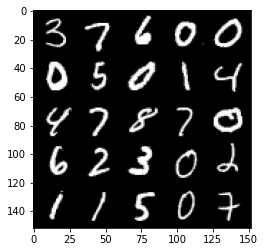

Step 2000: Generator loss: 2.677799855455761, discriminator loss: 0.28869404623564304


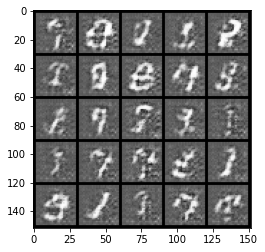

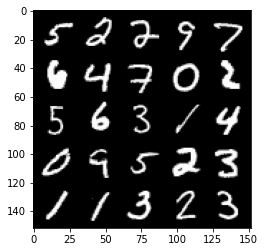

Step 3000: Generator loss: 1.4045610357336706, discriminator loss: 0.4405095615088942


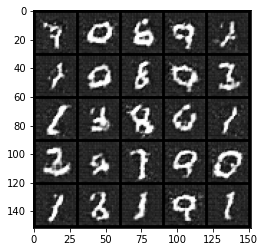

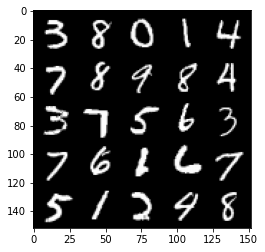

Step 4000: Generator loss: 1.2315098988860838, discriminator loss: 0.465758251041174


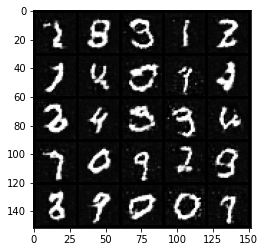

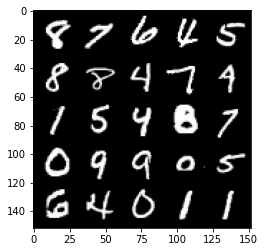

Step 5000: Generator loss: 1.165894384130837, discriminator loss: 0.4821987875699995


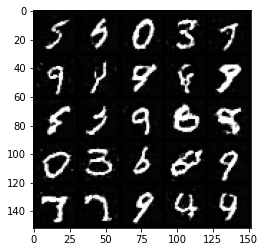

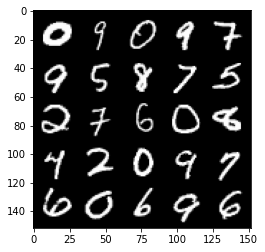

Step 6000: Generator loss: 1.1614454023838026, discriminator loss: 0.485606374531984


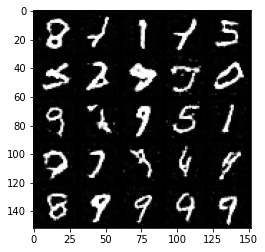

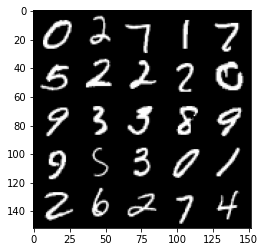

Step 7000: Generator loss: 1.1766289990842362, discriminator loss: 0.4869522861242293


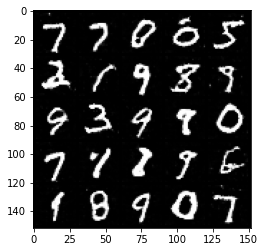

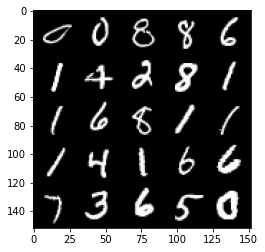

Step 8000: Generator loss: 1.1696762415766704, discriminator loss: 0.49383311659097623


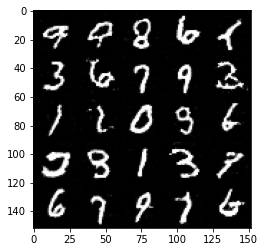

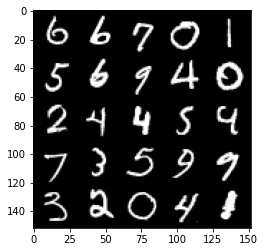

Step 9000: Generator loss: 1.1569018989205355, discriminator loss: 0.5006421091556548


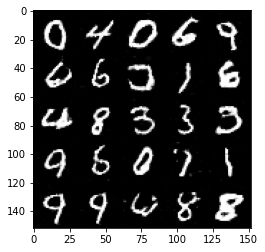

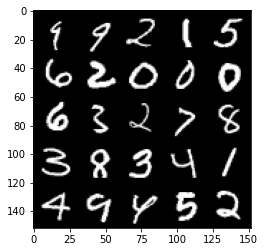

Step 10000: Generator loss: 1.1526816050559292, discriminator loss: 0.5079249588549136


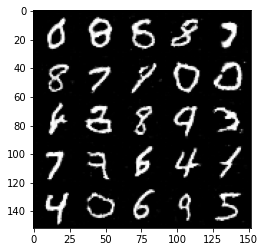

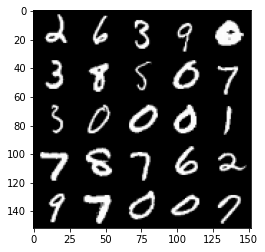

Step 11000: Generator loss: 1.137574715435505, discriminator loss: 0.5161695883870123


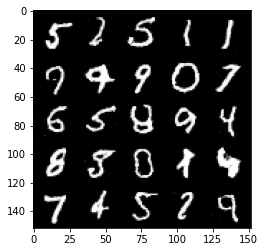

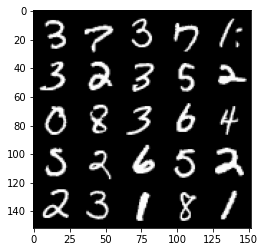

Step 12000: Generator loss: 1.118182814329863, discriminator loss: 0.5265923839509482


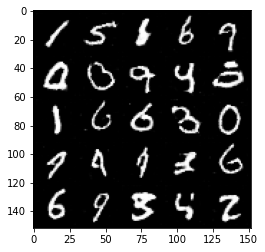

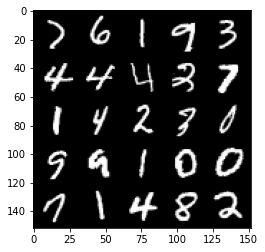

Step 13000: Generator loss: 1.110427756637334, discriminator loss: 0.5284487792551519


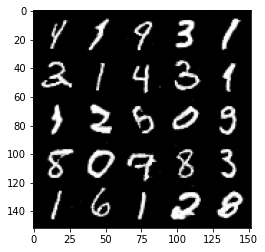

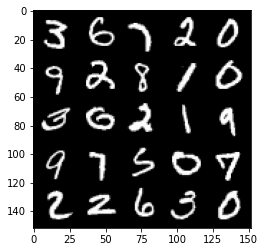

Step 14000: Generator loss: 1.0961641111969942, discriminator loss: 0.5362297630310063


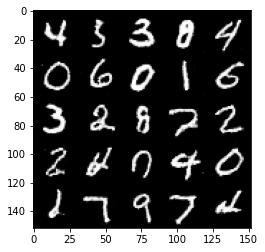

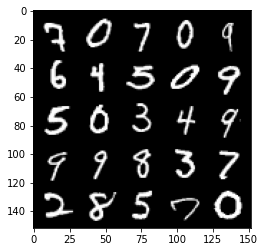

Step 15000: Generator loss: 1.0854349999129784, discriminator loss: 0.5413775264918805


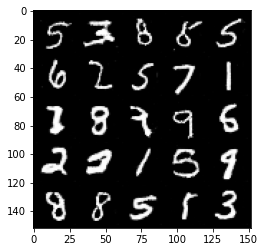

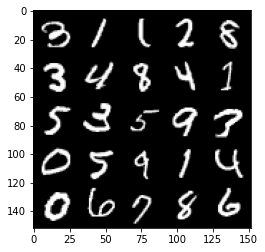

Step 16000: Generator loss: 1.0783699519634242, discriminator loss: 0.5484596903026107


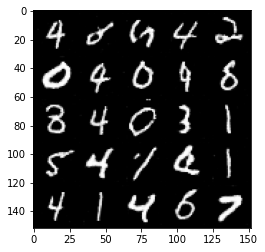

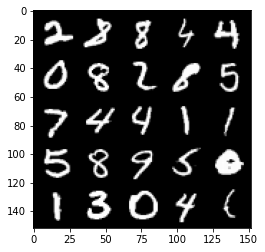

Step 17000: Generator loss: 1.0507453597486032, discriminator loss: 0.5584876244068145


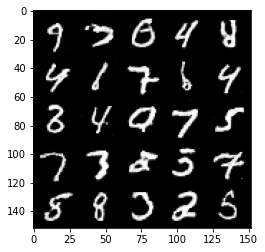

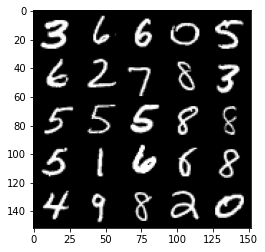

Step 18000: Generator loss: 1.0400419199168685, discriminator loss: 0.5640874635577201


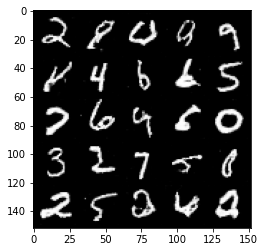

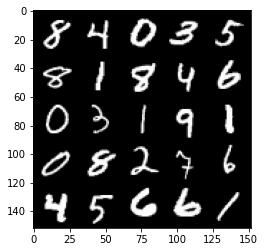

Step 19000: Generator loss: 1.0316214439272884, discriminator loss: 0.5670011205375189


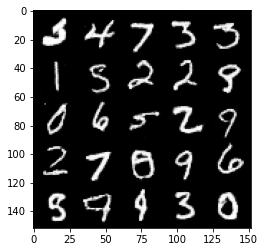

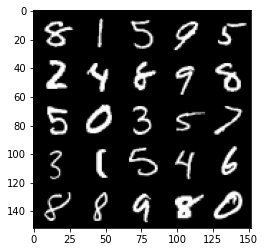

Step 20000: Generator loss: 1.0273107858896255, discriminator loss: 0.5699543706774713


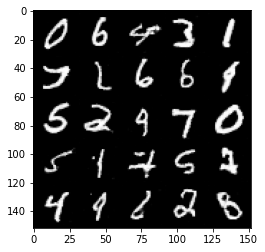

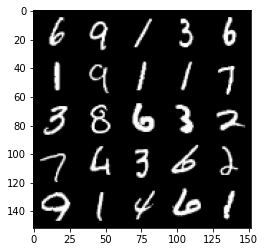

Step 21000: Generator loss: 1.0197747885584827, discriminator loss: 0.5762331542372703


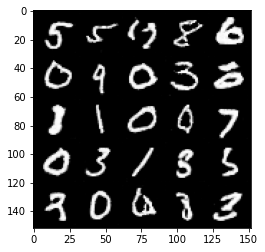

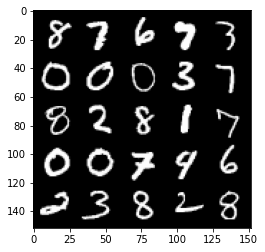

Step 22000: Generator loss: 1.0100109149515624, discriminator loss: 0.5811476661562922


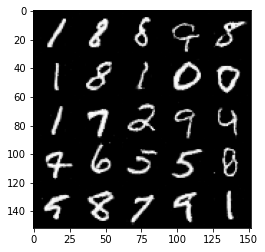

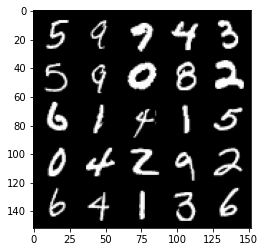

Step 23000: Generator loss: 1.0022113142609583, discriminator loss: 0.5834478830993177


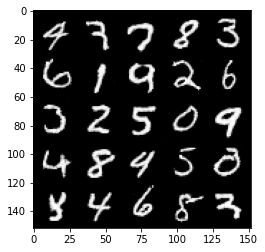

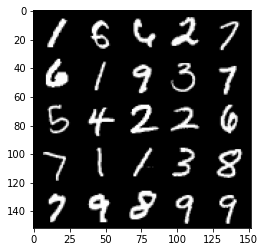

In [22]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(train_loader):
        cur_batch_size = real.size(0)
        real = real.to(device)

        ## Update discriminator ##
        D_opt.zero_grad()
        fake_noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
        fake = G(fake_noise)
        disc_fake_pred = D(fake.detach())
        disc_fake_loss = fake_loss(disc_fake_pred)#, torch.zeros_like(disc_fake_pred))

        disc_real_pred = D(real.detach())
        disc_real_loss = real_loss(disc_real_pred)#, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss)# / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        # disc_loss.backward(retain_graph=True)
        # Update optimizer
        # D_opt.step()
         #Backward pass for the discriminator
        disc_fake_loss.backward()
        disc_real_loss.backward()
        D_opt.step()



        ## Update generator ##
        G_opt.zero_grad()
        fake_noise_2 = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
        fake_2 = G(fake_noise_2)
        disc_fake_pred = D(fake_2)
        gen_loss = real_loss(disc_fake_pred)#, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        G_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

## Create more samples

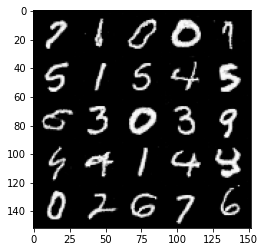

In [23]:
num_image = 30
noise = torch.randn(num_image, z_dim, device=device)
with torch.no_grad():
    fake_img = G(noise)
show_tensor_images(fake_img)